In [ ]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.special import softmax

In [103]:
df = pd.read_csv("../data/alligators.csv")
df["is_male"] = df["sex"] == "Male"
y = df["choice"]
X = df[["length", "is_male"]]

In [104]:
model = LogisticRegression(penalty=None)
model.fit(X, y)

LogisticRegression(penalty=None)

In [ ]:
length = np.linspace(df["length"].min(), df["length"].max(), 100)
X_test = pd.DataFrame(
    {
        "length": [*length, *length],
        "is_male": [*[True for _ in length], *[False for _ in length]],
    }
)

In [106]:
p = model.predict_proba(X_test)
p_male = p[:100, :]
p_female = p[100:]

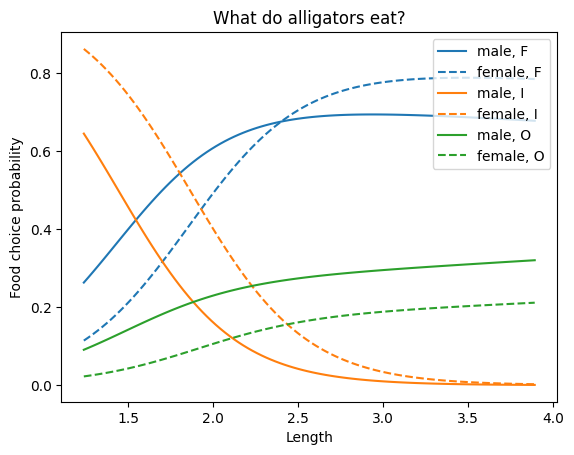

In [107]:
for i in range(3):
    plt.plot(length, p_male[:, i], label=f"male, {model.classes_[i]}")
    plt.plot(length, p_female[:, i], f"C{i}--", label=f"female, {model.classes_[i]}")
plt.legend(loc="upper right")

plt.ylabel("Food choice probability")
plt.xlabel("Length")

plt.title("What do alligators eat?")
plt.show()

In [143]:
U = model.intercept_ + X_test.to_numpy(dtype=float) @ model.coef_.T
q = np.exp(U) / np.sum(np.exp(U), axis=1, keepdims=True)
assert np.allclose(q, softmax(U, axis=1))
assert np.allclose(q, p)

In [ ]:
X = df[["length", "is_male"]].copy()
X["is_male"] = X["is_male"].astype(float)
X["Intercept"] = 1.0

In [219]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
yy = label_encoder.fit_transform(y)

fit = sm.MNLogit(yy, X).fit()
fit.summary()

Optimization terminated successfully.
         Current function value: 0.835253
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                      y   No. Observations:                   63
Model:                        MNLogit   Df Residuals:                       57
Method:                           MLE   Df Model:                            4
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                  0.1606
Time:                        19:28:35   Log-Likelihood:                -52.621
converged:                       True   LL-Null:                       -62.692
Covariance Type:            nonrobust   LLR p-value:                 0.0004681
==============================================================================
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length        -2.9274      0.936     -3.126      0.002      -4.763      -1.092
is_male       -1.1211      0.728     -1.540      0.124      -2.548       0.306
Intercept      5.6481      1.898      2.976      0.003       1.929       9.367
------------------------------------------------------------------------------
       y=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
length         0.1184      0.584      0.203      0.839      -1.025       1.262
is_male        0.5620      0.877      0.641      0.522      -1.157       2.281
Intercept     -1.7718      1.706     -1.038      0.299      -5.116       1.573
==============================================================================
"""

In [226]:
length = np.linspace(df["length"].min(), df["length"].max(), 100)
X_test = pd.DataFrame(
    {
        "length": [*length, *length],
        "is_male": [*[1.0 for _ in length], *[0.0 for _ in length]],
        "Intercept": [1.0 for _ in range(200)],
    }
)
assert np.allclose(fit.predict(X_test), q, atol=1e-3)

$$
\begin{aligned}
\log\frac{p(y=1)}{p(y=0)} &= X\beta_1\\
\log\frac{p(y=2)}{p(y=0)} &= X\beta_2\\
\end{aligned}
$$

$$
\begin{aligned}
p(y=1) &= p(y=0)e^{X\beta_1}\\
p(y=2) &= p(y=0)e^{X\beta_2}
\end{aligned}
$$

$$
1 = p(y=0) + p(y=1) + p(y=2) = p(y=0)(1 + e^{X\beta_1} + e^{X\beta_2})
$$

$$
p(y=0) = \frac1{1 + e^{X\beta_1} + e^{X\beta_2}}
$$

Set $\beta_0=0$. Then
$$
p(y=i) = \frac{e^{X\beta_i}}{e^{X\beta_0}+e^{X\beta_1}+e^{X\beta_2}}
$$

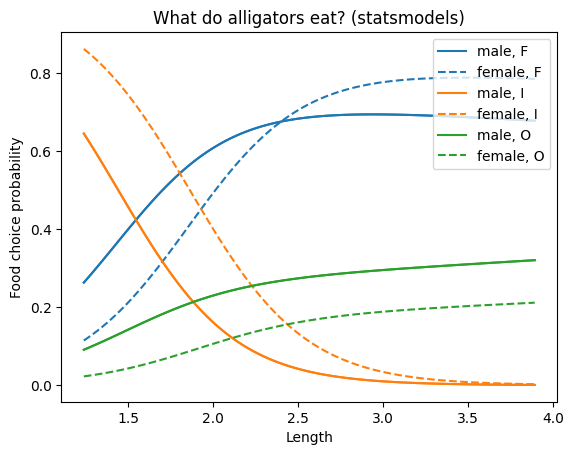

In [225]:
V = np.zeros((len(X_test), 3))
V[:, 1:] = (X_test @ fit.params).to_numpy()
W = softmax(V, axis=1)

plt.plot(length, W[:, 0].squeeze()[:100])
plt.plot(length, W[:, 1].squeeze()[:100])
plt.plot(length, W[:, 2][:100])

for i in range(3):
    plt.plot(length, W[:100, i], f"C{i}", label=f"male, {label_encoder.classes_[i]}")
    plt.plot(
        length, W[100:, i], f"C{i}--", label=f"female, {label_encoder.classes_[i]}"
    )
plt.legend(loc="upper right")

plt.ylabel("Food choice probability")
plt.xlabel("Length")

plt.title("What do alligators eat? (statsmodels)")
plt.show()

In [229]:
model = bmb.Model("choice ~ length + sex", df, family="categorical")
fit = model.fit()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, length, sex]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [231]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[I],5.881,1.871,2.591,9.530,0.032,0.024,3396.0,2897.0,1.0
Intercept[O],-1.898,1.737,-5.020,1.532,0.030,0.025,3309.0,2528.0,1.0
length[I],-3.060,0.924,-4.668,-1.304,0.016,0.012,3336.0,2685.0,1.0
length[O],0.111,0.602,-1.056,1.187,0.010,0.010,3562.0,2715.0,1.0
"sex[I, Male]",-1.161,0.719,-2.529,0.129,0.012,0.009,3663.0,3057.0,1.0
"sex[O, Male]",0.614,0.889,-1.060,2.260,0.014,0.012,3777.0,3059.0,1.0


In [251]:
df_new_female = pd.DataFrame({"length": length, "sex": ["Female" for _ in length]})

In [252]:
model.predict(fit, data=df_new_female)

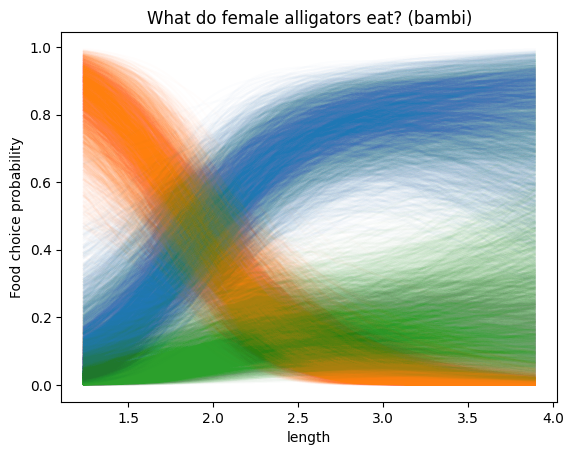

In [254]:
p = fit.posterior["p"]

for i in range(4):
    for j in range(1000):
        plt.plot(length, p[i, j, :, 0], "C0", alpha=0.01)
        plt.plot(length, p[i, j, :, 1], "C1", alpha=0.01)
        plt.plot(length, p[i, j, :, 2], "C2", alpha=0.01)

plt.xlabel("length")
plt.ylabel("Food choice probability")
plt.title("What do female alligators eat? (bambi)")
plt.show()

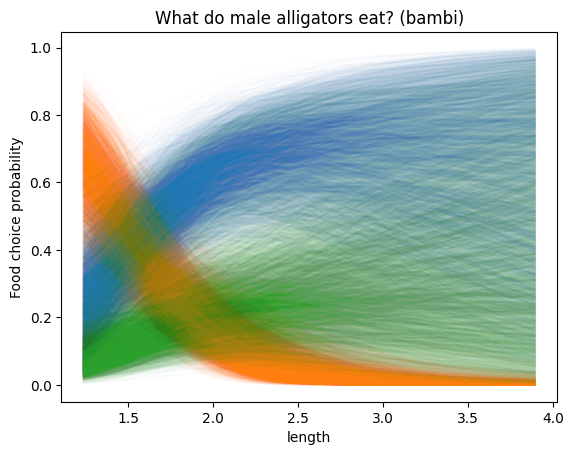

In [ ]:
df_new_male = pd.DataFrame({"length": length, "sex": ["Male" for _ in length]})

model.predict(fit, data=df_new_male)

p = fit.posterior["p"]

for i in range(4):
    for j in range(1000):
        plt.plot(length, p[i, j, :, 0], "C0", alpha=0.01)
        plt.plot(length, p[i, j, :, 1], "C1", alpha=0.01)
        plt.plot(length, p[i, j, :, 2], "C2", alpha=0.01)

plt.xlabel("length")
plt.ylabel("Food choice probability")
plt.title("What do male alligators eat? (bambi)")
plt.show()